# Training and Evaluation

### Import libraries

In [1]:
from __future__ import annotations
from pathlib import Path
import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import utils
warnings.filterwarnings('ignore')

### Import preprocessed train and test datasets

In [2]:
# import feature matrices
X_train = pd.read_csv(Path('data/preprocessed/X_train.csv')).values
X_test = pd.read_csv(Path('data/preprocessed/X_test.csv')).values
y_train = pd.read_csv(Path('data/preprocessed/y_train.csv'))
y_test = pd.read_csv(Path('data/preprocessed/y_test.csv'))

## Identify promising model(s) with first Cross Validation

### Cross-Validation

In [3]:
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet
from sklearn.neural_network import MLPRegressor
# from sklearn.svm import SVR, NuSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [4]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

from sklearn.model_selection import cross_val_score

def cross_validate_regressors(regressors, names, X_train, y_train, cv=10):
    scores = []
    for regressor in regressors:
        # what metric to use for scoring? 'neg_mean_absolute_error' or neg_root_mean_squared_error'
        scores.append(-cross_val_score(regressor, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv))
    scores = np.array(scores).T
    df_scores = pd.DataFrame(data=scores, columns=names)
    mean, std = df_scores.mean(axis=0), df_scores.std(axis=0)
    df_scores.loc['mean'] = mean
    df_scores.loc['std'] = std
    return df_scores

In [5]:
# Linear Regressors
# https://scikit-learn.org/stable/modules/linear_model.html
ridge = Ridge(alpha=1, max_iter=5000, tol=1e-3)
lasso = Lasso(alpha=0.1, max_iter=5000, tol=1e-3)
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)

# Ensemble Methods
# https://scikit-learn.org/stable/modules/ensemble.html
random_forest = RandomForestRegressor(n_estimators=100, # 500
                                      criterion='squared_error',
                                      max_features='auto',
                                      max_depth = 5,
                                      random_state=1)

GBR = GradientBoostingRegressor(random_state=0,
                                loss= 'squared_error',
                                learning_rate=0.3,
                                n_estimators=100,
                                criterion='squared_error',
                                min_samples_leaf=1,
                                subsample=0.5,
                                max_features='auto')

# Neural Networks
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html
mlp = MLPRegressor(
                hidden_layer_sizes=(20,20,20),
                activation = "tanh",
                solver='lbfgs', # small dataset
                alpha=0.9,
                learning_rate_init=1e-3,
                learning_rate='adaptive',
                random_state=1,
                batch_size=200,
                early_stopping=True,
                validation_fraction=0.1
                ) # 1.07 | 0.73


regressors = [ridge, lasso, elastic_net, random_forest, GBR, mlp]
names = ['ridge', 'lasso', 'elastic_net', 'random_forest', 'GBR', 'mlp']

# regressors = [mlp]
# names = ['mlp']


In [6]:
scores_cv = cross_validate_regressors(regressors, names, X_train, y_train.values.ravel(), cv=10)

In [7]:
scores_cv

,ridge,lasso,elastic_net,random_forest,GBR,mlp
0,11.405301,11.580478,11.768907,3.982668,6.258923,0.611176
1,13.492931,13.500539,14.615196,3.520019,4.311931,0.233394
2,9.955724,10.104322,9.611587,2.706202,5.127135,0.405353
3,12.218285,12.221387,13.260844,3.086438,4.386591,1.323849
4,8.864946,8.853210,10.749273,1.329056,3.205930,0.466780
5,10.576138,10.576165,11.060363,5.286452,6.672312,0.806798
6,15.732473,13.666274,9.723215,3.684431,3.737973,2.434721
7,9.566190,9.632712,10.673895,1.255444,2.669632,2.101562
8,11.190164,10.715587,11.817985,5.843330,5.781007,1.292273
9,9.592204,9.448804,9.754130,4.753557,6.761973,1.083302


Select best model: MLP

## Finetuning (Hyperparameter Optimization)

### Cross Validation (Round 1)

In [8]:
from sklearn.model_selection import GridSearchCV

In [9]:
param_grid = [
    {
        'hidden_layer_sizes': [(20,20,20), (40,40,20), (60,60,40),],
        'activation': ['tanh'],
        'solver': ['lbfgs'],    
        'alpha': [0.3, 0.5, 0.9],
        'learning_rate_init': [1e-3],
        'learning_rate': ['adaptive'],
        'random_state': [1],
        'batch_size': [200],
        'early_stopping': [True],
        'validation_fraction': [0.1],
    }
]

In [10]:
grid_search = GridSearchCV(MLPRegressor(), param_grid, cv=10, scoring='neg_mean_absolute_error', return_train_score=True)

In [11]:
grid_search = grid_search.fit(X_train, y_train.values.ravel())

In [12]:
def cv_results(cvres):
    # retrieve parameters used in grid search
    df_params = pd.DataFrame(cvres['params'])
    # drop columns which have a unique single value
    nunique = df_params.nunique()
    cols_to_drop = nunique[nunique == 1].index
    df_params.drop(cols_to_drop, axis=1, inplace=True)
    # attach scores
    df_scores = pd.DataFrame({'mean_test_score':-cvres['mean_test_score'], 'std_test_score':cvres["std_test_score"]})
    df_cvres = pd.concat([df_scores,df_params], axis=1)
    return df_cvres

In [13]:
df_cvres = cv_results(grid_search.cv_results_)

In [14]:
df_cvres

,mean_test_score,std_test_score,alpha,hidden_layer_sizes
0,0.986363,0.691983,0.3,"(20, 20, 20)"
1,0.844851,0.601602,0.3,"(40, 40, 20)"
2,0.899297,0.631467,0.3,"(60, 60, 40)"
3,1.486750,1.536413,0.5,"(20, 20, 20)"
4,0.939321,0.590427,0.5,"(40, 40, 20)"
5,0.593781,0.612360,0.5,"(60, 60, 40)"
6,1.075921,0.694665,0.9,"(20, 20, 20)"
7,0.685163,0.351199,0.9,"(40, 40, 20)"
8,0.791056,0.527450,0.9,"(60, 60, 40)"


### Cross Validation (Round 2):
extend hidden layer size search

In [15]:
param_grid_2 = [
    {
        'hidden_layer_sizes': [(60,60,40), (60,60,60), (120,40,20)],
        'activation': ['tanh'],
        'solver': ['lbfgs'],    
        'alpha': [0.5, 0.9],
        'learning_rate_init': [1e-3],
        'learning_rate': ['adaptive'],
        'random_state': [1],
        'batch_size': [200],
        'early_stopping': [True],
        'validation_fraction': [0.1],
    }
]

In [16]:
grid_search_2 = GridSearchCV(MLPRegressor(), param_grid_2, cv=10, scoring='neg_mean_absolute_error', return_train_score=True)
grid_search_2 = grid_search_2.fit(X_train, y_train.values.ravel())
df_cvres_2 = cv_results(grid_search_2.cv_results_)

In [17]:
df_cvres_2

,mean_test_score,std_test_score,alpha,hidden_layer_sizes
0,0.593781,0.612360,0.5,"(60, 60, 40)"
1,1.105985,0.760735,0.5,"(60, 60, 60)"
2,0.544938,0.307711,0.5,"(120, 40, 20)"
3,0.791056,0.527450,0.9,"(60, 60, 40)"
4,1.134338,0.559446,0.9,"(60, 60, 60)"
5,0.628470,0.444875,0.9,"(120, 40, 20)"


In [18]:
best_params = grid_search_2.cv_results_['params'][2]

In [19]:
best_params

{'activation': 'tanh',
 'alpha': 0.5,
 'batch_size': 200,
 'early_stopping': True,
 'hidden_layer_sizes': (120, 40, 20),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.001,
 'random_state': 1,
 'solver': 'lbfgs',
 'validation_fraction': 0.1}

## Evaluation

### Retrain MLP with best parameters

In [20]:
mlp = MLPRegressor(**best_params)
mlp = mlp.fit(X_train, y_train.values.ravel())

In [21]:
# compute training error
y_train_pred = mlp.predict(X_train)
errors_train = np.abs(y_train.values.ravel() - y_train_pred)
results_train = pd.DataFrame(data={"y_train":y_train.values.ravel(), 
                                  "y_pred":y_train_pred, 
                                  "error":errors_train})

In [22]:
results_train

,y_train,y_pred,error
0,49.5,49.431651,0.068349
1,52.3,52.294972,0.005028
2,19.8,19.841546,0.041546
3,49.5,49.437698,0.062302
4,49.7,49.600963,0.099037
...,...,...,...
251,49.7,50.016235,0.316235
252,52.3,52.218881,0.081119
253,49.5,49.426027,0.073973
254,100.8,100.961659,0.161659


### Evaluate on test set

In [23]:
# compute test error
y_test_pred = mlp.predict(X_test)
errors_test = np.abs(y_test.values.ravel() - y_test_pred)
results_test = pd.DataFrame(data={"y_test":y_test.values.ravel(), 
                                  "y_pred":y_test_pred, 
                                  "error":errors_test})

In [24]:
results_test

,y_test,y_pred,error
0,101.5,101.451326,0.048674
1,19.8,19.750628,0.049372
2,49.5,49.393690,0.106310
3,52.3,52.336750,0.036750
4,100.8,101.126652,0.326652
...,...,...,...
60,20.0,20.109045,0.109045
61,49.5,49.446163,0.053837
62,100.8,100.913607,0.113607
63,19.8,19.755352,0.044648


In [25]:
# Average train error vs. average test error
from sklearn import metrics
mae_train = metrics.mean_absolute_error(y_train.values.ravel(), y_train_pred)
rmse_train = metrics.mean_squared_error(y_train.values.ravel(), y_train_pred, squared=False)
print(f'MAE_train = {mae_train}\nRMSE_train = {rmse_train}\n')

mae_test = metrics.mean_absolute_error(y_test.values.ravel(), y_test_pred)
rmse_test = metrics.mean_squared_error(y_test.values.ravel(), y_test_pred, squared=False)
print(f'MAE_test = {mae_test}\nRMSE_test = {rmse_test}')

MAE_train = 0.09878313419547236
RMSE_train = 0.13735966937501867

MAE_test = 1.8452369824534554
RMSE_test = 10.527009686374361


### Test Error Distribution

Text(0, 0.5, 'Frequenz')

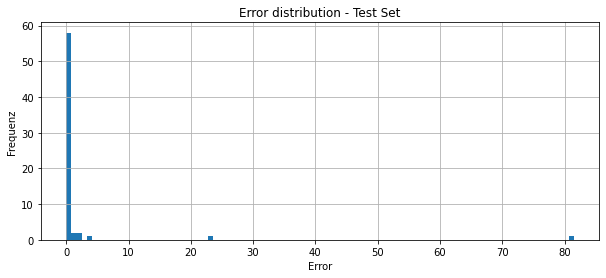

In [26]:
plt.figure(figsize=(10,4))
plt.hist(x=results_test['error'].values, bins=100)
plt.title('Error distribution - Test Set')
plt.grid()
plt.xlabel('Error')
plt.ylabel('Frequenz')

Text(0, 0.5, 'Frequenz')

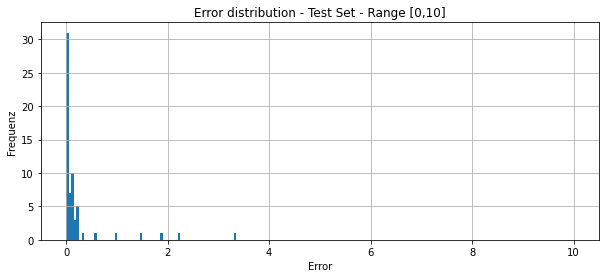

In [27]:
plt.figure(figsize=(10,4))
plt.hist(x=results_test['error'].values, bins=200, range=[0,10])
plt.title('Error distribution - Test Set - Range [0,10]')
plt.grid()
plt.xlabel('Error')
plt.ylabel('Frequenz')

In [28]:
per_under_1 = (results_test['error'] < 1).sum()/results_test['error'].size
print(f'Percentage of test errors under 1 mg/ml = {per_under_1*100:.3f}%')

Percentage of test errors under 1 mg/ml = 90.769%


In [29]:
threshold = 25
MAE_test_2 = results_test[['error']][results_test['error'] < threshold].values.mean()
print(f'MAE_test without oulier = {MAE_test_2:.2f} ')

MAE_test without oulier = 0.60 


### Investigate highest errors

In [30]:
df_info_test = pd.read_csv('data/preprocessed/df_info_test.csv', index_col=0)
df_info_test['error'] = results_test['error'].values

In [31]:
df_info_test.sort_values(by='error', axis=0, ascending=False)[0:10]

,subst,c,date,power,it,run,error
10,Pentan,20.0,17.12.2021,24.0,5.0,11,81.451560
95,Pentan,48.3,05.01.2022,24.0,10.0,6,23.348306
221,Pentan,19.8,05.01.2022,34.0,5.0,2,3.329682
307,Pentan,100.8,05.01.2022,34.0,5.0,8,2.210191
243,Pentan,48.3,05.01.2022,34.0,5.0,4,1.876500
119,Pentan,49.7,05.01.2022,24.0,10.0,10,1.499710
108,Pentan,49.7,05.01.2022,24.0,5.0,9,0.959582
103,Pentan,49.7,05.01.2022,24.0,5.0,4,0.598683
147,Pentan,100.8,05.01.2022,24.0,5.0,8,0.326652
121,Pentan,52.3,05.01.2022,24.0,5.0,2,0.248793


In [32]:
# dfi.export(df_info_test.sort_values(by='error', axis=0, ascending=False)[0:10], 'dataframe.png')

In [33]:
# identify the sprectrograms corresponding to the highest 3 errors
df_highest_errors = df_info_test.sort_values(by='error', axis=0, ascending=False)[0:3]
df_highest_errors

,subst,c,date,power,it,run,error
10,Pentan,20.0,17.12.2021,24.0,5.0,11,81.451560
95,Pentan,48.3,05.01.2022,24.0,10.0,6,23.348306
221,Pentan,19.8,05.01.2022,34.0,5.0,2,3.329682


### Outlier

In [34]:
df_info = pd.read_csv('data/preprocessed/df_info.csv', index_col=0)
df_raw = pd.read_csv('data/raw/df_raw.csv', index_col=0)
df_raw = utils.trim_data(df_raw, 'x', low=0, high=3000)

In [35]:
plot_params = {'xlabel':"Raman Shift $[cm^{-1}]$", 
               'ylabel':"Intensity", 
               'grid':'both',
               'figsize':(15,7), 
               'legend':None}

In [36]:
df_highest_errors.iloc[[0]]

,subst,c,date,power,it,run,error
10,Pentan,20.0,17.12.2021,24.0,5.0,11,81.45156


In [37]:
_, c, _, power, it, run, _ = df_highest_errors.iloc[0].values
c, power, it, run

(20.0, 24.0, 5.0, 11)

In [38]:
# spectrogram with high test error
cond = (df_info.c == c) & (df_info.power == power) & (df_info.it == it) & (df_info.run == run)
ii = [0] + list(df_info[cond].index + 1)
# spectrograms in the same group
bool_arr = (df_info.c == c) & (df_info.power == power) & (df_info.it == it) & (df_info.run != run)
index_arr = [0] + list(df_info[bool_arr].index + 1)

<AxesSubplot:title={'center':'Oulier vs Spectrograms of the same category (24 mW, 5sec)'}, xlabel='Raman Shift $[cm^{-1}]$', ylabel='Intensity'>

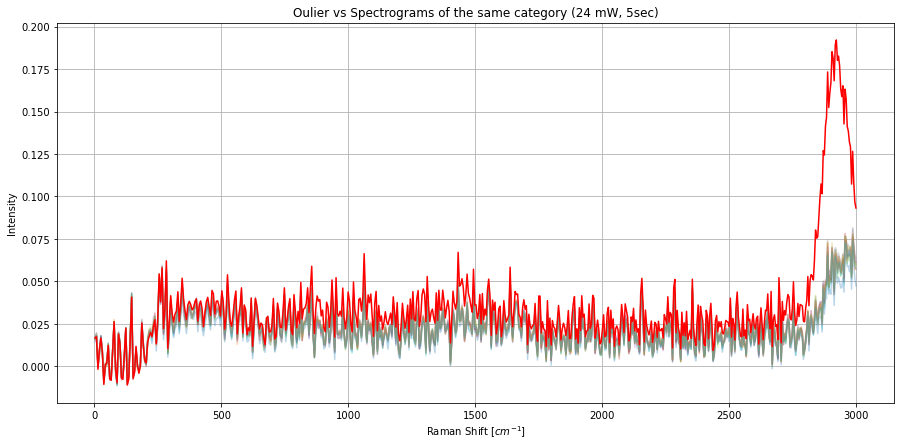

In [39]:
ax = df_raw.iloc[:,index_arr].plot(x='x', **plot_params, alpha=0.3, title='Oulier vs Spectrograms of the same category (24 mW, 5sec)')
df_raw.iloc[:,ii].plot(x='x', **plot_params, color='red', ax=ax)

-----

## Investigate test instances with 2nd and 3rd highest errors

### 2nd highest error

In [40]:
df_highest_errors.iloc[[1]]

,subst,c,date,power,it,run,error
95,Pentan,48.3,05.01.2022,24.0,10.0,6,23.348306


In [41]:
_, c, _, power, it, run, _ = df_highest_errors.iloc[1].values
c, power, it, run

(48.3, 24.0, 10.0, 6)

In [42]:
# spectrogram with high test error
cond = (df_info.c == c) & (df_info.power == power) & (df_info.it == it) & (df_info.run == run)
ii = [0] + list(df_info[cond].index + 1)
# spectrograms in the same group
bool_arr = (df_info.c == c) & (df_info.power == power) & (df_info.it == it) & (df_info.run != run)
index_arr = [0] + list(df_info[bool_arr].index + 1)

<AxesSubplot:xlabel='Raman Shift $[cm^{-1}]$', ylabel='Intensity'>

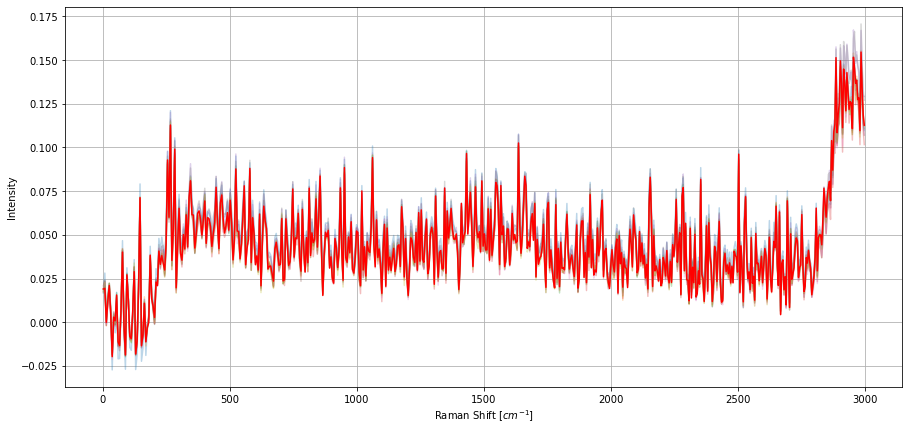

In [43]:
ax = df_raw.iloc[:,index_arr].plot(x='x', **plot_params, alpha=0.3)
df_raw.iloc[:,ii].plot(x='x', **plot_params, color='red', ax=ax)

### 3rd highest error

In [44]:
df_highest_errors.iloc[[2]]

,subst,c,date,power,it,run,error
221,Pentan,19.8,05.01.2022,34.0,5.0,2,3.329682


In [45]:
_, c, _, power, it, run, _ = df_highest_errors.iloc[2].values
c, power, it, run

(19.8, 34.0, 5.0, 2)

In [46]:
# spectrogram with high test error
cond = (df_info.c == c) & (df_info.power == power) & (df_info.it == it) & (df_info.run == run)
ii = [0] + list(df_info[cond].index + 1)
# spectrograms in the same group
bool_arr = (df_info.c == c) & (df_info.power == power) & (df_info.it == it) & (df_info.run != run)
index_arr = [0] + list(df_info[bool_arr].index + 1)

<AxesSubplot:xlabel='Raman Shift $[cm^{-1}]$', ylabel='Intensity'>

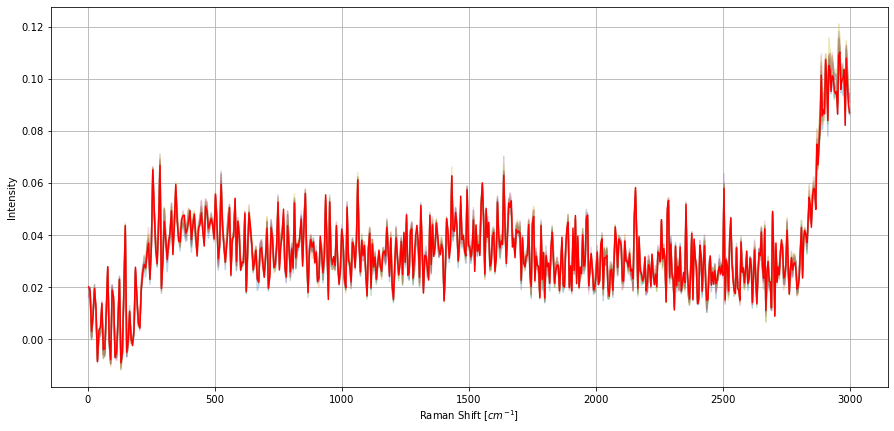

In [47]:
ax = df_raw.iloc[:,index_arr].plot(x='x', **plot_params, alpha=0.3)
df_raw.iloc[:,ii].plot(x='x', **plot_params, color='red', ax=ax)